# __가속도 데이터를 이용한 사람의 행동 예측하기__

<img src="https://miro.medium.com/max/2000/1*vjMyFvefRQbLix7WAyQA1w.png">
source = “Deep Neural Network Example” by Nils Ackermann is licensed under Creative Commons CC BY-ND 4.0

데이터 출처: http://www.cis.fordham.edu/wisdm/dataset.php

The WISDM 는 6개의 라벨을 가지고 있음(Downstairs, Jogging, Sitting, Standing, Upstairs, Walking). 

In [94]:
#필요한 라이브러리 가져오기
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, Adagrad, SGD, RMSprop

import matplotlib.pyplot as plt

## __데이터 전처리__

In [95]:
#파일 불러오기## __데이터 전처리__
def read_data(file_path):
    #파일의 속성은 실험자번호(user-id), activity, timestamp(unix time), x,y,z 
    column_names = ['user-id', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
    df = pd.read_csv(file_path, header=None,names=column_names) #필요없는 헤더는 버리고 사전에 지정한 column에 따라 불러오기
    
    #마지막 column에 있는 세미콜론 제거
    #정규식으로 제거하기
    df['z-axis'].replace(regex=True, inplace=True, to_replace=r';', value=r'')
    
    #마지막 z축이 object 형태로 반환되어서 float형태로 변환
    df['z-axis'] = df['z-axis'].apply(lambda x: float(x))

    #결측치 제거
    df.dropna(axis=0, how='any', inplace=True)

    return df

In [96]:
df = read_data('WISDM_at_v2.0_raw.txt')

C:\Users\kumi1\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## __데이터 확인해보기__

In [97]:
df.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,1679,Walking,1370520469556,0.294132,-0.635605,-0.226936
1,1679,Walking,1370520469606,-0.499688,-0.604451,-0.226020
2,1679,Walking,1370520469656,-2.178345,0.713491,0.372017
3,1679,Walking,1370520469706,-2.797763,1.354899,-0.277638
4,1679,Walking,1370520469756,-2.167961,-1.327716,-0.554971


In [98]:
#데이터 프레임 정보 확인. 2980765개의 데이터가 추가되었다 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2980765 entries, 0 to 3005410
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user-id    int64  
 1   activity   object 
 2   timestamp  object 
 3   x-axis     float64
 4   y-axis     float64
 5   z-axis     float64
dtypes: float64(3), int64(1), object(2)
memory usage: 159.2+ MB


In [99]:
#결측치 확인
#데이터를 불러올때 결측치를 제거했기 때문에 결측치가 존재하지 않는다
df.isnull().sum()

user-id      0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       0
dtype: int64

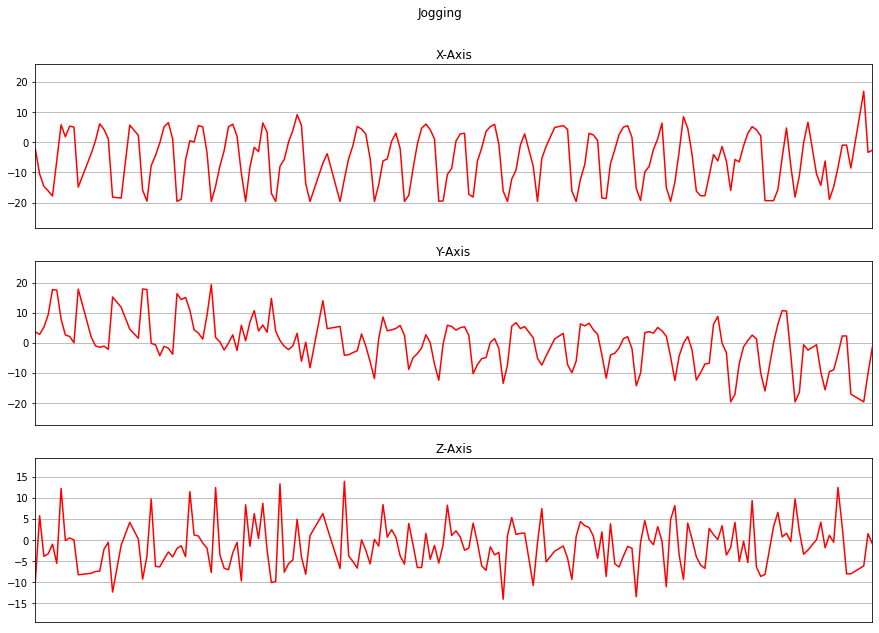

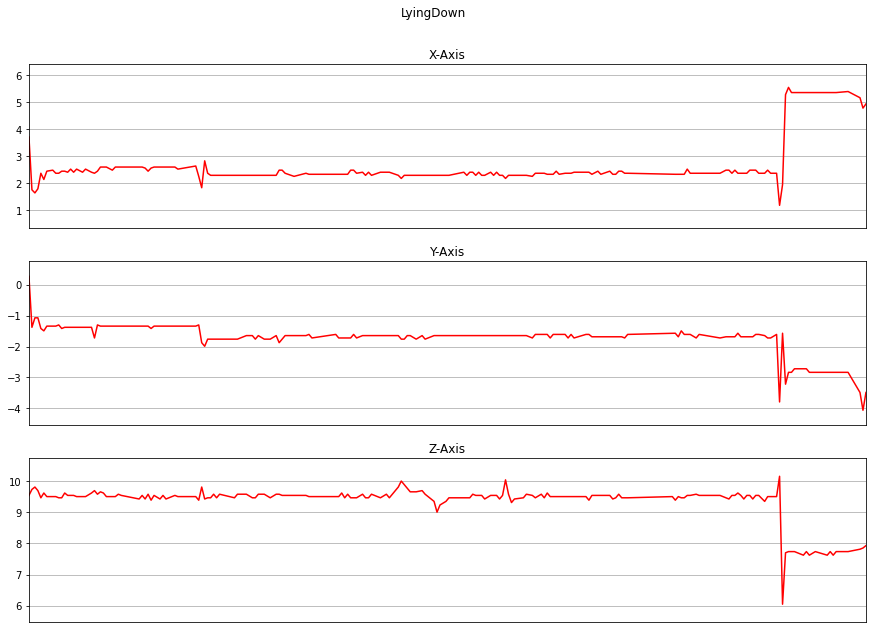

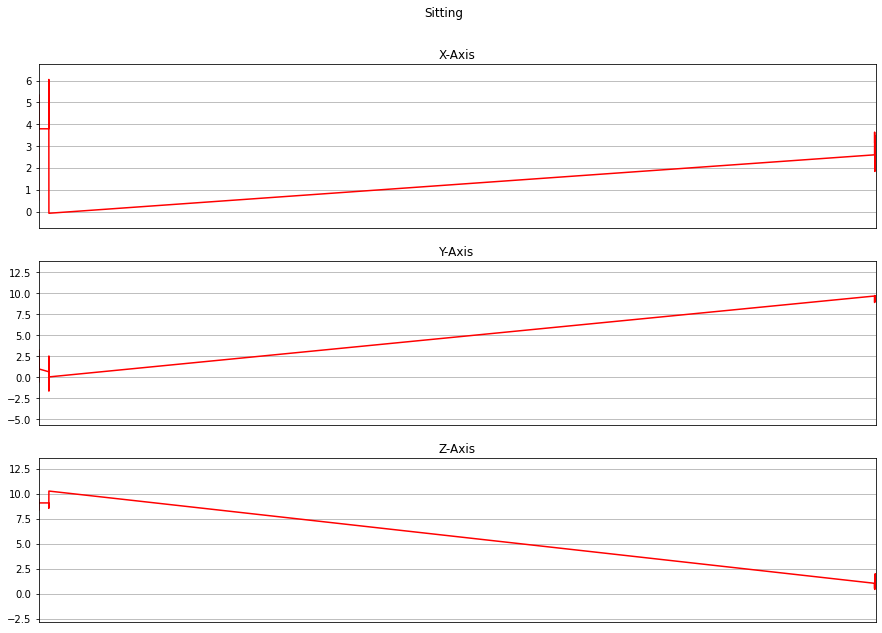

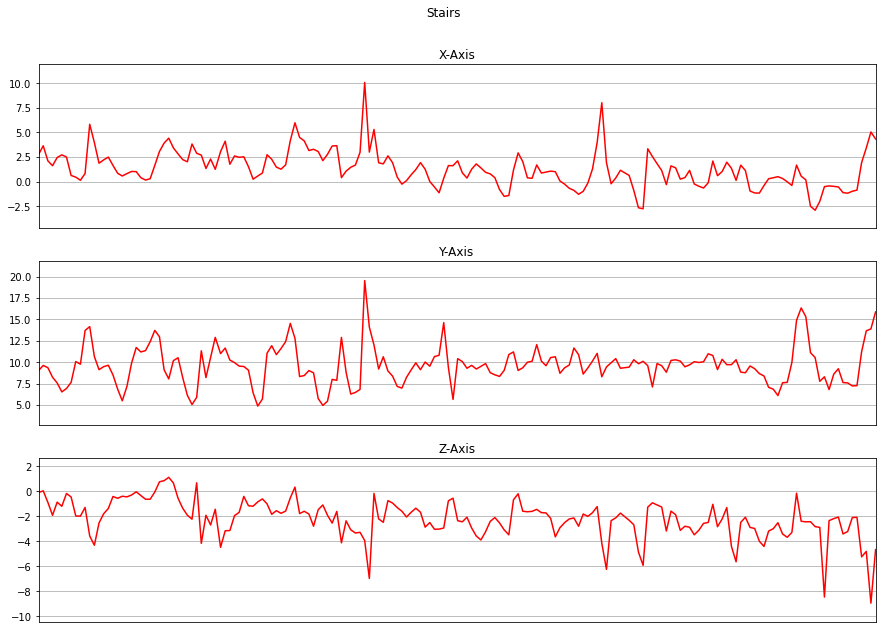

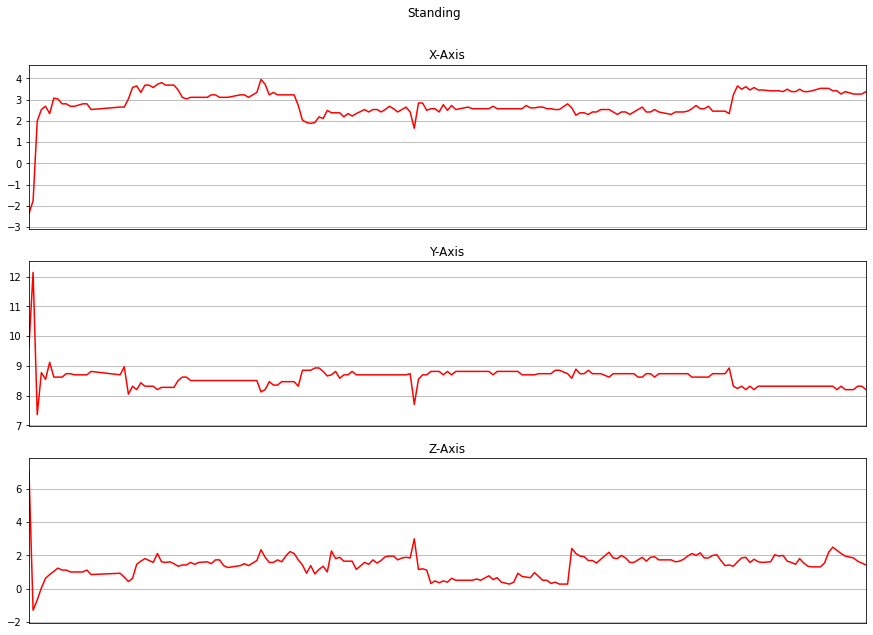

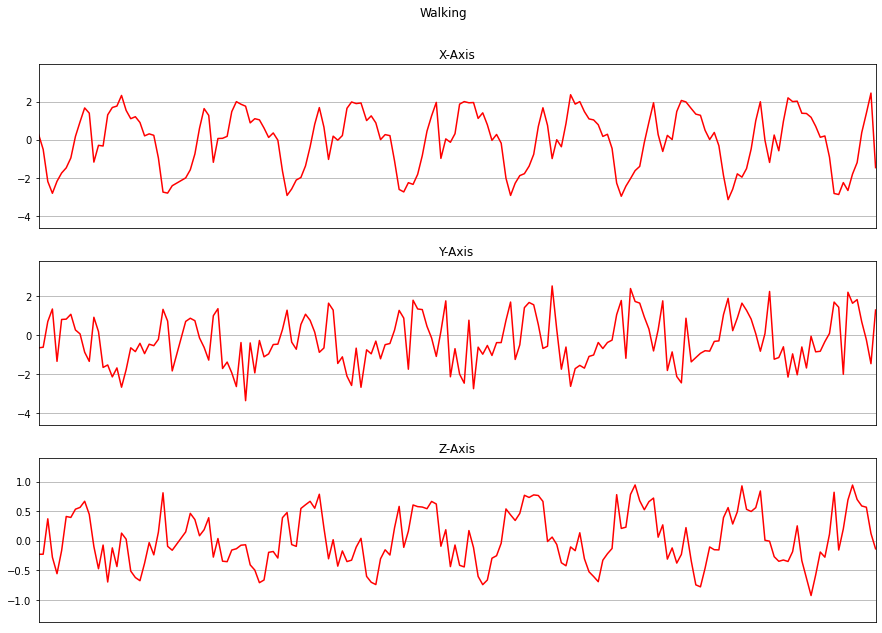

In [68]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

## __데이터 Label 변환하기__

In [100]:
# 6개의 라벨을 인코딩하기(0-5사이의 값으로 바꾸기)
labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

#LabelEncoder 사용
le = preprocessing.LabelEncoder()
#fit: LabelEncoder가 데이터 프레임에## __데이터 Label 변환하기__ 맞추도록 설정
#transform: 데이터 프레임에 맞게 설정된 LabelEncoder를 사용해 레이블 변경
df['ActivityEncoded'] = le.fit_transform(df['activity'].values.ravel())

In [101]:
#라벨 인코딩이 제대로 됐는지 확인
a = df['ActivityEncoded'].unique()
a.sort()
a

array([0, 1, 2, 3, 4, 5])

In [102]:
#실험자(user-id)에 따라서 train, test 셋 분리하기, 
#train : test  = 8 : 2 

users = df['user-id'].unique()
users.sort()
len(users), len(users)*0.8  #총 225명의 실험자가 있으며 user-id 를 오름차순으로 정렬했을 때 80%에 해당하는 user-id는 180

(225, 180.0)

In [103]:
a = df['user-id'].unique()
a.sort()
index_80_percent = a[int(len(a)*0.8)] #80%에 해당하는 실험자 번호 찾기

df_train = df[df['user-id'] <= index_80_percent ] #80%의 실험자를 train셋에 분류 
df_test = df[df['user-id'] > index_80_percent ] #20%의 실험자를 test셋에 분류

In [104]:
len(df_train), len(df_test), len(df_train)//len(df_test) #train : test = 8 : 2 비율이 맞는지 확인

(2422897, 557868, 4)

In [105]:
df_train.shape, df_test.shape

((2422897, 7), (557868, 7))

In [106]:
#trian 셋을 정규화(normalize)하기. 

df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

df_train.head()

<ipython-input-106-221b028f564b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
<ipython-input-106-221b028f564b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
<ipython-input-106-221b028f564b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
999,599,LyingDown,1200000000001,2.573026e-17,0.003346,1.612573e-20,1
1000,599,LyingDown,1200000000002,1.220198e-17,-0.017208,1.644954e-20,1
1001,599,LyingDown,1200000000003,1.140620e-17,-0.013384,1.657906e-20,1
1002,599,LyingDown,1200000000004,1.246724e-17,-0.013384,1.638478e-20,1
1003,599,LyingDown,1200000000005,1.644615e-17,-0.017686,1.599621e-20,1


In [107]:
def create_frames_and_labels(df, frame_size, step_size):

    # x, y, z 축까지 해서 3개의 feature
    N_FEATURES = 3
    
    # 프레임을 생성한다. 1개의 frame은 frame_size 인자로 받는다
    # step_size는 프레임간의 간격이다. 프레임들이 서로 겹치는 것을 피하기 위해 설정한다. 인자로 받는다
    
    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, step_size):
        xs = df['x-axis'].values[i: i + frame_size]
        ys = df['y-axis'].values[i: i + frame_size]
        zs = df['z-axis'].values[i: i + frame_size]
        
        # 프레임에서 가장 많이 나온 라벨을 해당 프레임의 라벨로 설정
        label = stats.mode(df['ActivityEncoded'][i: i + frame_size])[0][0]
        frames.append([xs, ys, zs])
        labels.append(label)

    # 프레임의 형태를 바꿔주기. float 형태로 바꿔주되 (frame_size, N_FEATURES) 형태로 맞춰주기
    reshaped_frames = np.asarray(frames, dtype= np.float32).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_frames, labels

## __데이터 프레임 준비하기__

In [108]:
#1개의 frame은 f(frequency) * seconds
frequency = 20
seconds = 10
frame_size = frequency*seconds 

#step_size는 1개 프레임 크기의 절반
step_size = frequency * seconds // 2

In [109]:
df_train.shape

(2422897, 7)

In [110]:
x_train, y_train = create_frames_and_labels(df_train, frame_size, step_size)

In [111]:
x_test, y_test = create_frames_and_labels(df_test, frame_size, step_size)

In [112]:
x_train.shape, y_train.shape #train 셋과 라벨이 올바르게 반한되었는지 확인

((24227, 200, 3), (24227,))

In [113]:
x_test.shape, y_test.shape

((5577, 200, 3), (5577,))

In [114]:
y_train #train 셋의 라벨이 사용하기 어려우므로 one-hot 인코딩을 사용해야한다

array([1, 1, 4, ..., 5, 5, 5])

In [115]:
y_train_hot = np_utils.to_categorical(y_train, 6) #one-hot 인코딩 사용

In [116]:
y_train_hot #one-hot 인코딩 결과 확인 

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

## __DNN 모델 적용해보기__

In [156]:
model = keras.Sequential() #순차 모델 생성

In [157]:
# model.add(Dense(100, activation='relu')) #100개 노드의 입력층 

model.add(Dense(32, activation='relu')) #100개 노드의 은닉층
model.add(Dense(64, activation='relu')) #100개 노드의 은닉층
model.add(Dense(128, activation='relu')) #100개 노드의 은닉층

model.add(Flatten()) #출력층에 넘기기 전에 Flatten
model.add(Dense(6, activation='softmax')) #softmax 함수를 거쳐 확률 계산

In [158]:
#손실함수(loss function)으로 crosse entropy를 사용
#최적화(optimizer) 방법으로 adam 사용. adagrad, sgd 중에서 adam이 가장 성능이 좋았음
#성과 측정 지표로 정확도(accuray) 사용
#모델 컴파일하기 
model.compile(optimizer=Adam(learning_rate = 0.01), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [159]:
#배치 사이즈는 200. 200개의 입력 데이터가 한번에 들어감 (200*frame_size*N_FEATURES)
#EPOCHS 숫자만큼 반복 훈련
BATCH_SIZE = 400
EPOCHS = 20

In [160]:
x_train.shape, y_train_hot.shape

((24227, 200, 3), (24227, 6))

In [161]:
#훈련 진행 
#검증(validation)셋은 20%로 잡아 하이퍼파라미터 조정에 사용
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=1)

Epoch 1/20
49/49 [==============================] - 3s 56ms/step - loss: 291211.6562 - accuracy: 0.5946 - val_loss: 0.6516 - val_accuracy: 0.8060
Epoch 2/20
49/49 [==============================] - 3s 57ms/step - loss: 91445.4688 - accuracy: 0.7097 - val_loss: 0.5718 - val_accuracy: 0.8240
Epoch 3/20
49/49 [==============================] - 3s 58ms/step - loss: 0.7282 - accuracy: 0.7252 - val_loss: 0.5032 - val_accuracy: 0.8500
Epoch 4/20
49/49 [==============================] - 3s 56ms/step - loss: 0.6892 - accuracy: 0.7370 - val_loss: 0.5303 - val_accuracy: 0.8423
Epoch 5/20
49/49 [==============================] - 3s 56ms/step - loss: 88980.9844 - accuracy: 0.7364 - val_loss: 0.5497 - val_accuracy: 0.8147
Epoch 6/20
49/49 [==============================] - 3s 56ms/step - loss: 0.6971 - accuracy: 0.7282 - val_loss: 0.5418 - val_accuracy: 0.8267
Epoch 7/20
49/49 [==============================] - 3s 55ms/step - loss: 0.6684 - accuracy: 0.7382 - val_loss: 0.5333 - val_accuracy: 0.8440


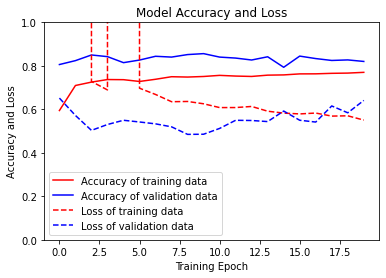

              precision    recall  f1-score   support

           0       0.93      0.75      0.83      4261
           1       0.45      0.10      0.17      2260
           2       0.56      0.86      0.68      4823
           3       0.75      0.31      0.44       252
           4       0.60      0.67      0.63      1616
           5       0.92      0.91      0.91     11015

    accuracy                           0.77     24227
   macro avg       0.70      0.60      0.61     24227
weighted avg       0.78      0.77      0.76     24227



In [162]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))